# Tempo

Tempo should be measured as either the amount of passes and dribbles per time frame, or the speed of those per time frame. It could also include for example goal kicks, free kicks, corner kicks and even shots. Let's start with passes and dribbles.

In [37]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [38]:
# global variables
timeframe = 1200/4 # 1200 is the duration of one period

In [39]:
# read data
df = pd.read_csv('../data/timelines.csv')

In [40]:
# head
df.head(1)

,tournament_id,match_id,event_type,period,result,team,seconds_from_period_start,start_time,end_time,start_position_x,...,speed,home_team,away_team,home_team_int,away_team_int,age,year,distance,duration,int_level
0,57,1257,KickOff,1.0,NaN,Home,NaN,NaN,NaN,NaN,...,NaN,FC Espoo T2010,EPS T2010,0,0,F12,2022,NaN,NaN,0


In [41]:
# group by matches
df_matches = df.groupby('match_id')

In [42]:
# get matches with time gaps between events of over 50 seconds
threshold = 50

# Compute time gaps
df['time_gap'] = df_matches['seconds_from_period_start'].diff()

# Identify matches with gaps above threshold
df['gap_exceeds_threshold'] = df['time_gap'] > threshold
df['gap_exceeds_threshold_300'] = df['time_gap'] > 300

In [43]:
# get matches where two consecutive events are kick-offs
df['consecutive_kickoffs'] = (df['event_type'] == 'KickOff') & (df['event_type'].shift(1) == 'KickOff')

In [44]:
# get matches with under 300 events
event_counts = df.groupby('match_id').size().reset_index(name='event_count')
too_few_events_ids = event_counts['match_id'][event_counts['event_count'] < 300]

We should decide which matches we want to keep. Some matches have large gaps between events, which could be pauses in the match or an error of the data gathering system. Below are a few options.

In [45]:
# remove matches where two consecutive events are kickoffs and have at least a 50 second gap
# remove_match_indices = df[(df['gap_exceeds_threshold'] == True) & (df['consecutive_kickoffs'] == True)]['match_id'].unique()
# df = df[~df['match_id'].isin(remove_match_indices)]

In [46]:
# remove matches with time gaps of over five minutes and matches with less than 300 events
remove_match_indices = df[(df['gap_exceeds_threshold_300'] == True)]['match_id'].unique()
remove_match_indices = list(set(remove_match_indices) | set(too_few_events_ids))
df = df[~df['match_id'].isin(remove_match_indices)].copy()

In [47]:
# finally, create a match info df with match ids, teams, internationality, age and year
match_info_df = df.loc[:, ['match_id', 'home_team', 'away_team',
                           'home_team_int', 'away_team_int', 'int_level',
                           'age', 'year']].drop_duplicates(subset=['match_id'])

### Plotting

In [48]:
# Function to calculate passes, dribbles & shots per timeframe
def calculate_tempo(df, timeframe):
    
    # Create time bins
    df.loc[:,'time_bin'] = (df['seconds_from_period_start'] // timeframe) * timeframe
    
    # Count passes, dribbles & shots per time bin
    df = df[df['event_type'].isin(['Pass', 'Dribble', 'Shot', 'ThrowIn', 'FreeKick', 'GoalKick', 'CornerKick'])] \
        .groupby(['match_id', 'time_bin', 'age', 'int_level']).size().reset_index(name='tempo')
    
    return df

In [49]:
# get the tempo dataframe
tempo_df = calculate_tempo(df, timeframe)

In [50]:
# print distribution of match durations to drop time bins with only a few instances
tempo_df['time_bin'].value_counts()

time_bin
600.0     430
900.0     430
1200.0    430
300.0     429
1500.0    429
0.0       428
1800.0    408
2100.0    299
2400.0    268
2700.0     19
3000.0     13
3300.0      1
Name: count, dtype: int64

We can see that only a few matches have played over the 2400 second mark. We should ignore these time bins as they are not representative of the population.

In [ ]:
# exclude the last incomplete time frames

# Find the max time_bin for each match_id
max_time_bins = tempo_df.groupby('match_id')['time_bin'].transform('max')

# Keep only rows where time_bin is NOT the max for that match
tempo_df = tempo_df[tempo_df['time_bin'] != max_time_bins]
tempo_df = tempo_df[tempo_df['time_bin'] <= 2100]

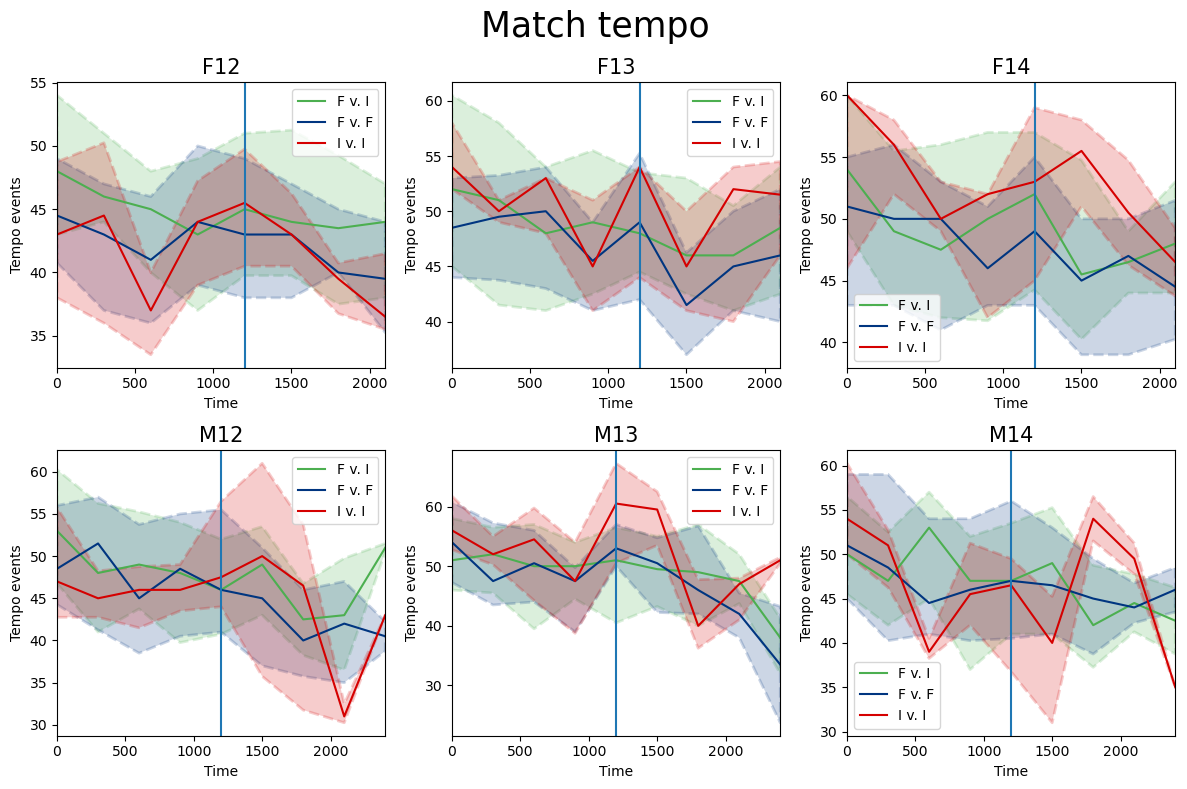

In [61]:
# plot tempo in a line plot by age groups
fig, axes = plt.subplots(2,3, figsize=(12,8))

colors = ['#003580', '#4caf50', '#d50000'] # blue, green, red

axes = axes.flatten()

df_grouped = tempo_df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):

    # Group by int_level within each age group
    int_levels = df_group['int_level'].unique()  # Get unique intensity levels

    for level in int_levels: # [1, 0, 2]
        subset = df_group[df_group['int_level'] == level]
        avg = subset.groupby('time_bin')['tempo'].median()
        l_q = subset.groupby('time_bin')['tempo'].quantile(q=0.25)
        h_q = subset.groupby('time_bin')['tempo'].quantile(q=0.75)
        axes[i].plot(avg, color=colors[level], label=f'{['F v. F', 'F v. I', 'I v. I'][level]}')
        axes[i].fill_between(avg.index, l_q, h_q, color=colors[level], alpha=.2, linestyle='--', linewidth=2, interpolate=True)
        
    axes[i].set_xlim([avg.index[0], avg.index[-1]])
    axes[i].set_title(group_name, fontsize=15)
    axes[i].axvline(1200)
    axes[i].legend()  # Add legend to differentiate int_level categories
    axes[i].set_xlabel('Time', fontsize=10)
    axes[i].set_ylabel('Tempo events', fontsize=10)

fig.suptitle('Match tempo', fontsize=25)
plt.tight_layout()

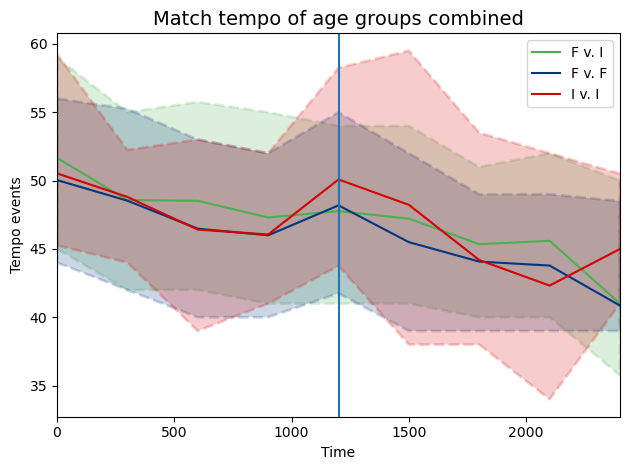

In [62]:
# plot tempo

colors = ['#003580', '#4caf50', '#d50000']

# Group by int_level within each age group
int_levels = tempo_df['int_level'].unique()  # Get unique intensity levels

for level in int_levels: # [1, 0, 2]
    subset = tempo_df[tempo_df['int_level'] == level]
    l_q = subset.groupby('time_bin')['tempo'].quantile(q=0.25)
    h_q = subset.groupby('time_bin')['tempo'].quantile(q=0.75)
    avg = subset.groupby('time_bin')['tempo'].mean()
    plt.plot(avg, color=colors[level], label=f'{['F v. F', 'F v. I', 'I v. I'][level]}')
    plt.fill_between(avg.index, l_q, h_q, color=colors[level], alpha=.2, linestyle='--', linewidth=2, interpolate=True)

plt.xlim([avg.index[0], avg.index[-1]])
plt.title('Match tempo of age groups combined', fontsize=14)
plt.axvline(1200)
plt.legend()  # Add legend to differentiate int_level categories
plt.xlabel('Time')
plt.ylabel('Tempo events')

plt.tight_layout()

We will focus next on the team-wise tempo per possession. For this we need to first derive the team in position in each moment. Then we can derive the duration of said possession, and calculate the amount of passes and dribbles per possession.

In [54]:
# simplify data frame
simple_df = df[['match_id', 'event_type', 'team', 'result', 'seconds_from_period_start', 'home_team_int', 'away_team_int', 'age', 'time_gap', ]]

We will next calculate possessions. Possession is classified as at least three consecutive events of the same team. The duration of the possession is calculated. Large gaps within possessions are ignored, and replaced with the average gap between two passes of the team in the match. The events in a possession are counted, and then the tempo of the possession is calculated as events/minute.

In [55]:
# group by matches
grouped_matches = simple_df.groupby('match_id')

# initialize list to store possession dfs of individual matches
df_list = []


for group_name, df_group in grouped_matches:

    # create a possession identifier by checking when the value changes
    df_group.loc[:, 'possession_id'] = (df_group['team'] != df_group['team'].shift()).cumsum()

    # calculate possession duration
    df_group.loc[:, 'possession_duration'] = df_group.groupby('possession_id')['seconds_from_period_start'].transform('max') - \
                                df_group.groupby('possession_id')['seconds_from_period_start'].transform('min')

    # compute average pass gap in possession to help reduce gaps
    df_group.loc[:, 'prev_event_type'] = df_group.groupby('possession_id')['event_type'].shift(1)
    home_pass_avg_gap = df_group.loc[(df_group['event_type'] == 'Pass') & (df_group['prev_event_type'] == 'Pass') & (df_group['team'] == 'Home'), 'time_gap'].mean()
    away_pass_avg_gap = df_group.loc[(df_group['event_type'] == 'Pass') & (df_group['prev_event_type'] == 'Pass') & (df_group['team'] == 'Away'), 'time_gap'].mean()

    # Filter possessions that have at least 3 events
    valid_possessions = df_group.groupby(['match_id', 'team', 'possession_id']).filter(lambda x: len(x) >= 3)

    # Detect if any possession has a gap ≥ 10 seconds
    possessions_with_gaps = (
        valid_possessions.groupby(['match_id', 'team', 'possession_id'])['time_gap']
        .apply(lambda x: x.iloc[1:].max())  # Skip first row and take max
        .reset_index(name='max_time_gap')
    )
    possessions_with_gaps['has_large_gap'] = possessions_with_gaps['max_time_gap'] >= 10

    # Group by possession and calculate tempo event counts
    df_possessions = valid_possessions.groupby(['match_id', 'possession_id']).agg(
        pos_duration=('possession_duration', 'first'),
        pos_start_time=('seconds_from_period_start', 'first'),
        tempo_event_count=('event_type', lambda x: x.isin(['Pass', 'Dribble', 'Shot', 'ThrowIn', 'FreeKick', 'GoalKick', 'CornerKick']).sum()),  # Count passes
    ).reset_index()

    df_possessions = df_possessions.merge(possessions_with_gaps, on=['match_id', 'possession_id'], how='left')

    # remove large gaps from possessions to limit pauses in possessions
    df_possessions['new_possession_duration'] = df_possessions.apply(
        lambda row: row['pos_duration'] - (row['max_time_gap'] - home_pass_avg_gap) if ((row['has_large_gap']) & (row['team'] == 'Home')) 
                        else (row['pos_duration'] - (row['max_time_gap'] - away_pass_avg_gap) if ((row['has_large_gap']) & (row['team'] == 'Away'))
                        else row['pos_duration']),
        axis=1)
    
    # remove possessions with duration 0
    df_possessions = df_possessions[df_possessions['pos_duration'] != 0]

    # Calculate tempo as events per minute
    df_possessions['pos_tempo'] = (df_possessions['tempo_event_count']) / (df_possessions['pos_duration']/60)

    # add df to list
    df_list.append(df_possessions)

# combine match dfs
pos_tempo_df = pd.concat(df_list, ignore_index=True)

In [56]:
# combine team internationality, age and year to the dataframe
pos_tempo_df = pos_tempo_df.merge(match_info_df.loc[:, ['match_id', 'home_team_int', 'away_team_int', 'age', 'year']],
                    how='left', on='match_id')

In [105]:
pos_tempo_df

,match_id,possession_id,pos_duration,pos_start_time,tempo_event_count,team,max_time_gap,has_large_gap,new_possession_duration,pos_tempo,home_team_int,away_team_int,age,year,pos_int,time_bin
0,1237,1,4.0,1.0,2,Away,4.0,False,4.000000,30.000000,0,1,F12,2022,1,0.0
1,1237,40,16.0,187.0,4,Away,7.0,False,16.000000,15.000000,0,1,F12,2022,1,0.0
2,1237,43,8.0,237.0,3,Home,5.0,False,8.000000,22.500000,0,1,F12,2022,0,0.0
3,1237,47,15.0,262.0,4,Home,6.0,False,15.000000,16.000000,0,1,F12,2022,0,0.0
4,1237,51,10.0,290.0,5,Away,4.0,False,10.000000,30.000000,0,1,F12,2022,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19213,3301,313,79.0,2555.0,11,Home,41.0,True,42.579365,8.354430,0,0,M12,2024,0,2400.0
19214,3301,317,8.0,2685.0,3,Away,4.0,False,8.000000,22.500000,0,0,M12,2024,0,2400.0
19215,3301,344,6.0,2860.0,3,Home,4.0,False,6.000000,30.000000,0,0,M12,2024,0,2700.0
19216,3301,351,35.0,2893.0,3,Away,20.0,True,19.366667,5.142857,0,0,M12,2024,0,2700.0


Now we have a dataframe of all matches with possessions as instances. Each possession has a duration and event count from which the tempo is calculated. Now we can analyse the differences of possessional tempo of international vs. Finnish teams.

In [78]:
# calculate new dataframe of average values of international and finnish teams by age groups for plotting

# possessions teams internationality
def possession_internationality(row):
    if row['team'] == 'Home':
        return row['home_team_int']
    elif row['team'] == 'Away':
        return row['away_team_int']
    else:
        return np.nan

pos_tempo_df.loc[:, 'pos_int'] = pos_tempo_df.apply(possession_internationality, axis=1)

# Create time bins of 5 minutes
pos_tempo_df.loc[:, 'time_bin'] = (pos_tempo_df['pos_start_time'] // timeframe) * timeframe

# compute medians and quantiles
df_grouped = pos_tempo_df.groupby(['age', 'pos_int', 'time_bin'])['pos_tempo'].agg(
    median=lambda x: x.median(),
    q25=lambda x: x.quantile(0.25),
    q75=lambda x: x.quantile(0.75)
).reset_index()

In [79]:
df_grouped

,age,pos_int,time_bin,median,q25,q75
0,F12,0,0.0,24.000000,18.000000,36.000000
1,F12,0,300.0,25.714286,16.363636,36.000000
2,F12,0,600.0,25.714286,15.000000,36.000000
3,F12,0,900.0,22.500000,14.779412,30.000000
4,F12,0,1200.0,25.714286,16.590909,34.285714
...,...,...,...,...,...,...
116,M14,1,2100.0,22.500000,18.461538,30.000000
117,M14,1,2400.0,17.500000,11.770833,27.656250
118,M14,1,2700.0,19.000000,17.357143,25.000000
119,M14,1,3000.0,9.476268,4.901216,19.384615


In [58]:
# check frequence of time bins
pos_tempo_df['time_bin'].value_counts()

time_bin
0.0       2934
300.0     2681
600.0     2597
1200.0    2532
900.0     2498
1500.0    2405
1800.0    1669
2100.0    1524
2400.0     286
2700.0      74
3000.0      14
3300.0       1
Name: count, dtype: int64

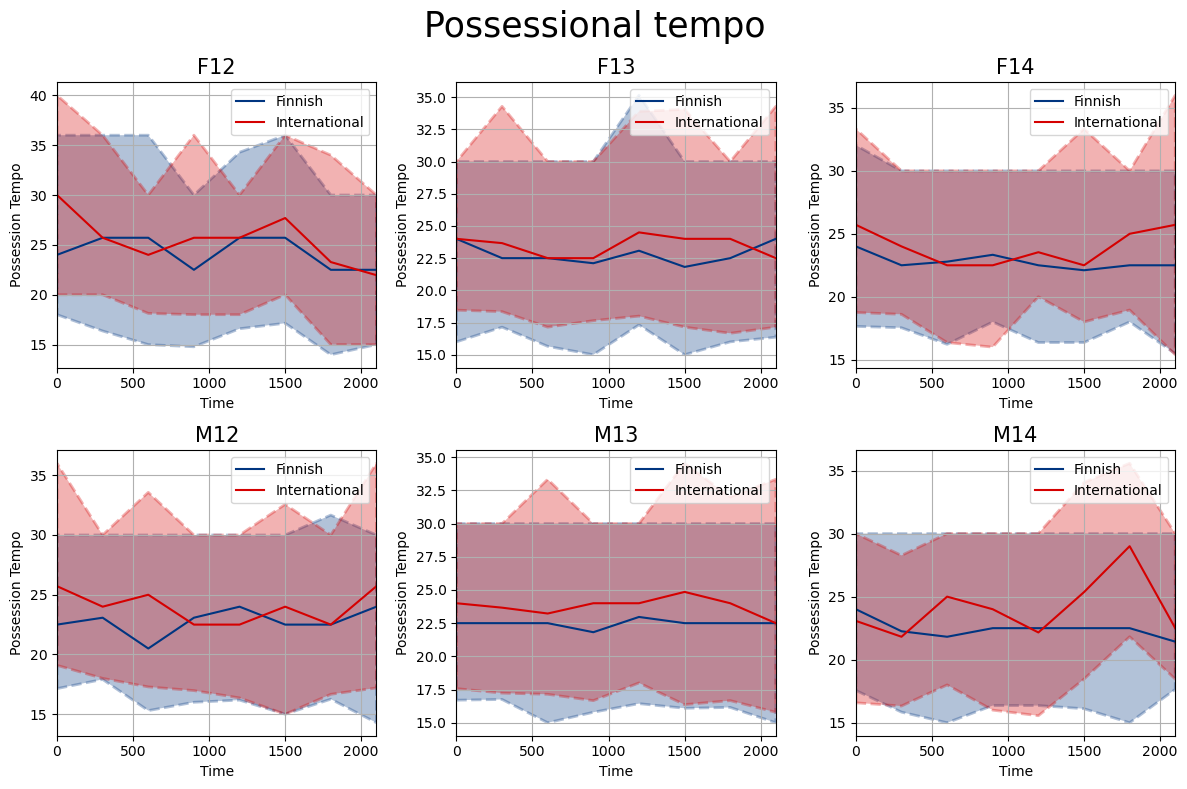

In [104]:
# plot possessional average tempos by age group and team internationality

# age groups
ages = df_grouped.groupby('age')

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

colors = ['#003580', '#d50000']

for i, (age, age_df) in enumerate(ages):
    ax = axes[i]

    pos_ints = age_df.groupby('pos_int')

    for pos_int_val, pos_int in pos_ints:
        df_filtered = pos_int[pos_int['time_bin'] <= 2100] # drop time bins after the full time
        ax.plot(df_filtered['time_bin'], df_filtered['median'], color=colors[pos_int_val], label=f'{['Finnish', 'International'][pos_int_val]}')
        ax.fill_between(df_filtered['time_bin'], df_filtered['q25'], df_filtered['q75'], color=colors[pos_int_val], alpha=.3, linestyle='--', linewidth=2, interpolate=True)

    ax.set_xlim([df_filtered.iloc[0, 2], df_filtered.iloc[-1, 2]])
    ax.set_title(f'{age}', fontsize=15)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel('Possession Tempo', fontsize=10)
    ax.legend()
    ax.grid(True)

fig.suptitle('Possessional tempo', fontsize=25)
plt.tight_layout()  # Adjust layout for readability
plt.show()
